In [1]:
from matplotlib import pyplot as plt
import rospy

from alr_sim.sims.SimFactory import SimRepository
from alr_sim.core import Scene
from alr_sim.sims.universal_sim.PrimitiveObjects import Box

from grasp_benchmark.utils.ros_utils import call_grasp_planner
from grasp_benchmark.utils.ycb_utils import YCBLoader

pybullet build time: Oct 28 2022 16:11:27


No module named 'py_at_broker'
No SL installed. SL simulation and control is not available.
No module named 'py_at_broker'
No SL or ROS installed. SL_ROS simulation and control is not available.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
graspnet_service = "/graspnet_bench/graspnet_grasp_planner_service"
superquadrics_service = "/superquadric_bench/superq_grasp_planner_service"
gpd_service = "/gpd_bench/gpd_grasp_planner/gpd_grasp_planner_service"
dexnet_service = "/dexnet_bench/dexnet_grasp_planner_service"
grconvnet_service = "/grconvnet_bench/grconvnet_grasp_planner_service"

In [3]:
# get the objects in the scene

box1 = Box(
    name="box1",
    init_pos=[0.5, -0.2, 0.0],
    init_quat=[0, 1, 0, 0],
    rgba=[0.1, 0.25, 0.3, 1],
)
object_list = [box1]

In [4]:
# create the scene

# a node must be initialized before using ROS
# also make sure that ROS is running by typing "roscore" in a terminal
# rospy.init_node("simplified_new")

# Generate the Scene and Agent
sim_factory = SimRepository.get_factory("mj_beta")
scene = sim_factory.create_scene(object_list=object_list, dt=0.0003, render=Scene.RenderMode.HUMAN)
agent = sim_factory.create_robot(scene, dt=0.0003)

# get the camera object
# cam = scene.get_object("rgbd_cage")
cam = agent.inhand_cam
cam.set_cam_params(height=480, width=640)

In [5]:
# execute movements

scene.start()
# go to start position
agent.gotoCartPositionAndQuat((0.32, 0.0, 0.56), (0, 1, 0, 0), duration=0.5)
agent.wait(4)

# call the grasp planner
# grasps = call_grasp_planner(
#     cam, service_id, target_obj_id, num_of_candidates=n_candidates
# )

Final IK error (71 iterations):  8.164605835164435e-06
Final IK error (66 iterations):  9.798820337204746e-06


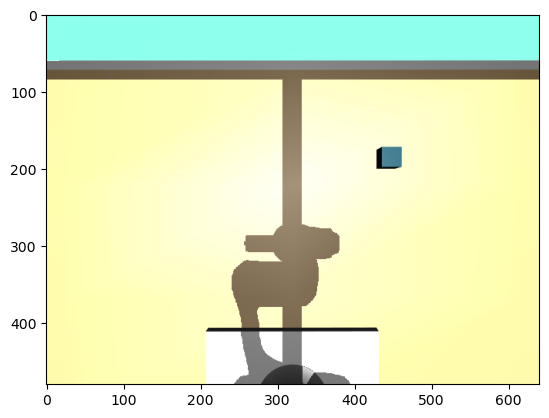

: 

In [6]:
# take picture etc

rgb_img, _ = cam.get_image()
plt.imshow(rgb_img)